In [23]:
import math
import pypot.dynamixel
from pypot.dynamixel.conversion import dxl_code
from pypot.dynamixel.conversion import dxl_decode
from time import sleep

from lib import Motor
import control_tables
from utils import read_from_file, dxl_decode_value

import matplotlib
import matplotlib.pyplot as plt
from utils import write_in_file
import numpy as np

## Setting up the motors

In [24]:
DXL_ID = 10
PORT = "/dev/ttyUSB0"
INPUT_TENSION = 12.78

configs = {
    "MX-106": {"resistance": 2.0, "torque_constant": 2.3593725498111775},
    "MX-64": {"resistance": 3.6, "torque_constant": 8.011176076962043},
}

In [25]:
# Lock all other motors
protocol_v2_motors = [11, 12, 13]
positions = [90, 180, 180]
with pypot.dynamixel.Dxl320IO(PORT) as dxl_io:
    for index, motor_id in enumerate(protocol_v2_motors):
        motor = Motor(
            dxl_io,
            motor_id,
            control_tables.MX_64,
            configs['MX-64']['resistance'],
            configs['MX-64']['torque_constant'],
            INPUT_TENSION
        )

        motor.torque_enabled = False
        motor.mode = 3
        motor.torque_enabled = True
        motor.goal_position = positions[index]

        print(f"Motor {motor_id} set")

Motor 11 set
Motor 12 set
Motor 13 set


In [26]:
# Setup shoulder
dxl_io = pypot.dynamixel.Dxl320IO(PORT)
motor = Motor(dxl_io, DXL_ID, control_tables.MX_106, configs['MX-106']['resistance'], configs['MX-106']['torque_constant'], INPUT_TENSION)

motor.torque_enabled = False
motor.mode = 16 # PWM Control mode
motor.torque_enabled = True
motor.motor_tension = 0

## Finding the maximum values we have to deliver

In [27]:
MASSE = 1.670 - 0.240  # Masse de l'objet en kg
DISTANCE = 0.45  # Distance de la masse à l'axe de rotation en mètres
GRAVITE = 9.81  # m/s²

couple_gravite = MASSE * DISTANCE * GRAVITE

torques = []
positions = []

for position in range(900, 2000):
    positions.append(position / 10)
    torques.append(couple_gravite * -math.cos(math.radians(positions[-1])))

Maximum torque: 6.312735


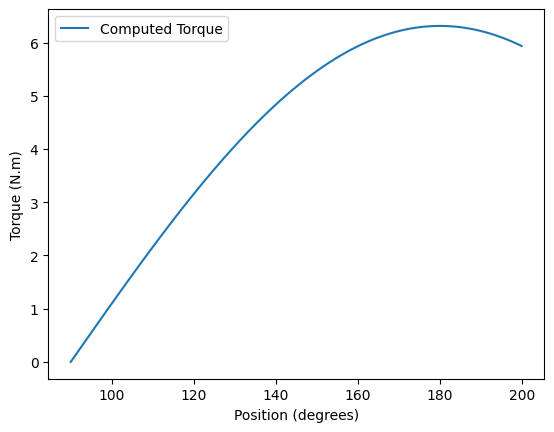

In [28]:
maximum_torque = max(torques)

print(f"Maximum torque: {maximum_torque}")

plt.figure()

plt.plot(positions, torques, label="Computed Torque")
plt.xlabel("Position (degrees)")
plt.ylabel("Torque (N.m)")
plt.legend()

plt.show()

In [29]:
max_tension = (maximum_torque / configs['MX-106']['torque_constant']) * configs['MX-106']['resistance']
print(f"Max tension to deliver: {max_tension} V")

pwm_limit = round((885 * round(max_tension, 1)) / INPUT_TENSION)
print(f"PWM limit: {pwm_limit}")

Max tension to deliver: 5.351198139950567 V
PWM limit: 374


## Benchmarking the motor's torque precision

In [30]:
motor.pwm_limit = pwm_limit

real_currents = []
computed_currents = []
real_torque = []
computed_torque = []
pwms = []

for pwm_unit in range(0, 25):
    motor.pwm = pwm_unit
    pwms.append(pwm_unit)

    computed_current = ((INPUT_TENSION * pwm_unit * 0.113) / 100) / configs['MX-106']['resistance']
    computed_currents.append(computed_current)
    real_currents.append(motor.motor_tension / configs['MX-106']['resistance'])

    computed_torque.append(computed_current * configs['MX-106']['torque_constant'])
    real_torque.append(motor.torque)

write_in_file(computed_currents, "computed_currents.txt")
write_in_file(real_currents, "real_currents.txt")
write_in_file(computed_torque, "computed_torque.txt")
write_in_file(real_torque, "real_torque.txt")
write_in_file(pwms, "pwms.txt")

motor.pwm = 0
motor.torque_enabled = False

Les values ont été écrites dans le fichier computed_currents.txt avec succès.
Les values ont été écrites dans le fichier real_currents.txt avec succès.
Les values ont été écrites dans le fichier computed_torque.txt avec succès.
Les values ont été écrites dans le fichier real_torque.txt avec succès.
Les values ont été écrites dans le fichier pwms.txt avec succès.


In [31]:
computed_currents = np.array(read_from_file("computed_currents.txt"))
real_currents = np.array(read_from_file("real_currents.txt"))
computed_torque = np.array(read_from_file("computed_torque.txt"))
real_torque = np.array(read_from_file("real_torque.txt"))
pwms = np.array(read_from_file("pwms.txt"))

Current standard deviation: 0.12285066049267582


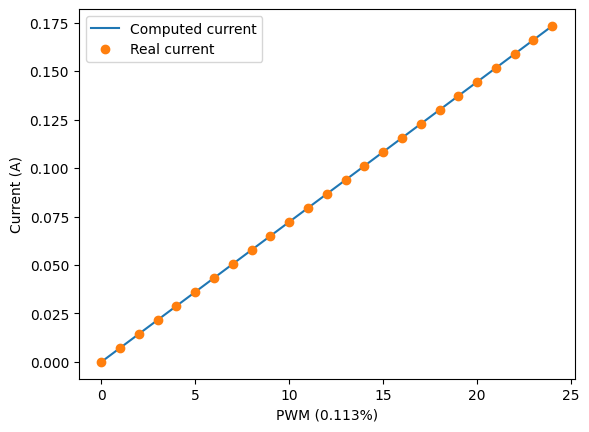

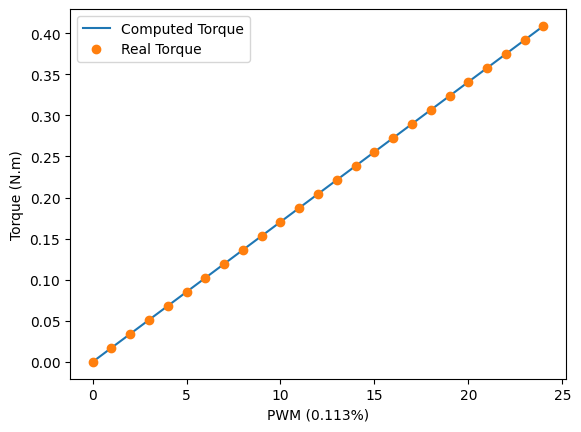

In [32]:
current_std_deviation = np.std(real_torque)

print(f"Current standard deviation: {current_std_deviation}")

plt.figure()

plt.plot(pwms, computed_currents, label="Computed current")
plt.plot(pwms, real_currents, "o", label="Real current")

plt.xlabel("PWM (0.113%)")
plt.ylabel("Current (A)")
plt.legend()

plt.figure()

plt.plot(pwms, computed_torque, label="Computed Torque")
plt.plot(pwms, real_torque, "o", label="Real Torque")

plt.xlabel("PWM (0.113%)")
plt.ylabel("Torque (N.m)")
plt.legend()

plt.show()

In [34]:
n = len(computed_torque)
sum_base =abs(computed_torque - real_torque).sum()
sum_square = ((computed_torque - real_torque) *(computed_torque - real_torque)).sum()

print(f'Torque mean Absolute Error : {sum_base/n}')
print(f'Torque mean Squared Error : {sum_square/n}')
print(f'Torque root Mean Squared Error : {np.sqrt(sum_square/n)}')

n = len(computed_currents)
sum_base =abs(computed_currents - real_currents).sum()
sum_square = ((computed_currents - real_currents) *(computed_currents - real_currents)).sum()

print(f'Current mean Absolute Error : {sum_base/n}')
print(f'Current mean Squared Error : {sum_square/n}')
print(f'Current root Mean Squared Error : {np.sqrt(sum_square/n)}')

Torque mean Absolute Error : 1.27675647831893e-17
Torque mean Squared Error : 5.9318642287126866e-34
Torque root Mean Squared Error : 2.435541875787129e-17
Current mean Absolute Error : 5.551115123125783e-18
Current mean Squared Error : 1.1940765655200862e-34
Current root Mean Squared Error : 1.0927381047259615e-17
